# Problem Set 2 Code and Writeup
### by Scott Behmer, January 22, 2018
The code in this Jupyter notebook was written using Python 3.6. It uses data file `clms.txt`. For the code to run properly, you should have the data file and the image file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data to reflect the location of that data.

This problem set involves fitting various statistical distributions to health expense data using maximum liklihood estimation.

## Part A. Setup and Histograms
Here the data is loaded, summary statistics are presented, and histograms are created.

In [31]:
#Loading Function Libraries
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
#Importing Special Functions (for gamma function)
import scipy.special as spc

#Importing Data
data = np.loadtxt('clms.txt')

The mean is: 720.277975327
The max is: 227967.25
The min is: 0.01
The median is: 172.21
The standard deviation is: 3972.66375639


<IPython.core.display.Javascript object>


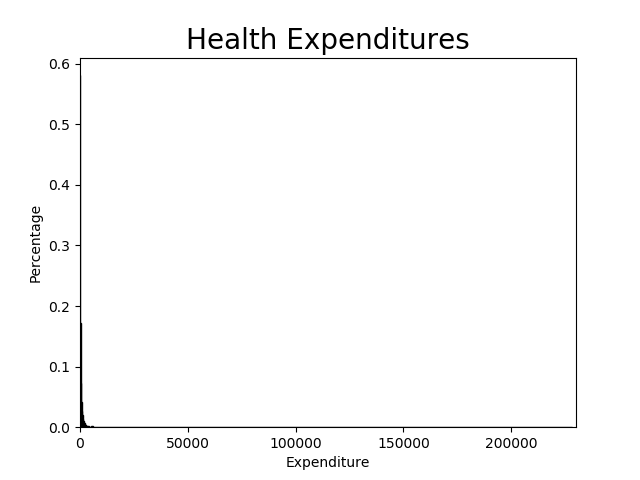

In [33]:
#Printing Summary Statistics
print("The mean is:", np.mean(data))
print("The max is:", max(data))
print("The min is:", min(data))
print("The median is:", np.median(data))
print("The standard deviation is:", np.std(data))

import matplotlib.pyplot as plt
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
#Note that the weight function is used so that the height of each bar represents the percentage of observations
#  that fall within that bin. The sum of all bar heights should be one. The integral, however, will not be one.
count, bins, ignored = plt.hist(data, 1000, edgecolor='black', weights = np.divide(np.ones(len(data)),len(data)))
plt.title('Health Expenditures', fontsize=20)
plt.xlabel('Expenditure')
plt.ylabel('Percentage')
plt.xlim([0, 230000]);

The histogram above is difficult to see because the data has such a long upper tail. This indicates that most people spend small amounts on health care (in this sample, 85% of the data is less than 800), but some spend far more. If we are to get a visual of how well different distributions fit the data, it will be easier to focus on the lower end of the distribution where most of the data is found. Below is a histogram for the observations between 0 and 800.

<IPython.core.display.Javascript object>


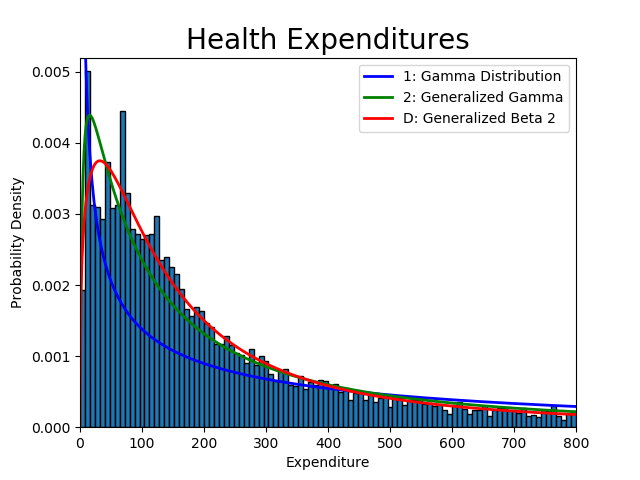

In [34]:
#Creating histogram
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
#Here the weights are chosen so that the integral of the entire range (that is, from .01 to 227978) would sum to one.
count, bins, ignored = plt.hist(data, 100, range = (0, 800), edgecolor='black', weights = np.divide(np.ones(len(data)), len(data)*8))
plt.title('Health Expenditures', fontsize=20)
plt.xlabel('Expenditure')
plt.ylabel('Probability Density')
plt.xlim([0, 800]);
plt.ylim([0, .0052]);

The heights of the bars in this plot represent _densities_, rather than frequencies or percentages. This means that we can directly compare the heights of the bars to the heights of various pdfs that will be fit to the data. The integral over the range of this plot is .849, indicating that nearly 85% of the observations fall within this range.

In [35]:
#Finding integral of the histogram from zero to 800
sum(count)*8

0.84942084942084595

## Part B: Maximum Likelihood Estimation for Gamma Distribution

The code below finds the parameters of the gamma distribution that maximize the log likelihood function of the data. It then plots the estimated pdf on the histogram above.

Notice that the minimization function outputs warnings regarding invalid parameters. As far as I can tell, this is due to the search algorithm moving to impossible parameter values (like beta < 0). However, it doesn't seem to affect the ability of the minimization function to find the correct parameters. The function successfully exits after 82 iterations.

The fitted distribution seems to capture the upper tail of the distribution fairly well, but it fails at the lower numbers (the histogram seems to peak at a value greater than zero, while the calibrated gamma pdf is always decreasing). It also significantly underestimates the likelihood between expense values of about 30 and 300. As we move to more general distributions, we will see that these other features of the data are better captured.

In [36]:
#Defining gamma pdf function
def gamma_pdf(xvals, alpha, beta):
    pdfvals = (1/(beta**alpha))*(xvals**(alpha-1))*np.exp(-(xvals/beta))/(spc.gamma(alpha))
    return pdfvals

#Defining log likelihood function
def log_lik_gamma(xvals, alpha, beta):
    #pdf_vals = sts.gamma.pdf(xvals, alpha, 0, scale=beta)
    pdf_vals = gamma_pdf(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

#Defining Criteria Function which will be minimized
def crit(params, *args):
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

#Calculating initial guesses based on the expected value and variance of the gamma distribution
beta0 = np.std(data)*np.std(data)/np.mean(data)
alpha0 = np.mean(data)/beta0

#Finding MLE using the minimize function
params_init = np.array([alpha0, beta0])
results = opt.minimize(crit, params_init, args=(data), method = 'Nelder-Mead')
alpha_MLE, beta_MLE = results.x
print('alpha_MLE=', alpha_MLE, ' beta_MLE=', beta_MLE)

#Adding gamma distribution to plot
dist_pts = np.linspace(0, 800, 500)
plt.plot(dist_pts, gamma_pdf(dist_pts, alpha_MLE, beta_MLE),
         linewidth=2, color='b', label='B: Gamma Distribution')
plt.legend(loc='upper right');

C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


alpha_MLE= 0.472513005902  beta_MLE= 1524.35587305


C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
#This cell will print the results of the optimization. We see that it succeeded in finding a local minimum.
results

 final_simplex: (array([[  4.72513006e-01,   1.52435587e+03],
       [  4.72513018e-01,   1.52435578e+03],
       [  4.72513016e-01,   1.52435586e+03]]), array([ 77723.47342497,  77723.47342497,  77723.47342497]))
           fun: 77723.473424965734
       message: 'Optimization terminated successfully.'
          nfev: 158
           nit: 82
        status: 0
       success: True
             x: array([  4.72513006e-01,   1.52435587e+03])

## Part C: MLE for Generalized Gamma Distribution

Following the same procedure as with the gamma distribution, the code below estimates parameters for the generalized gamma distribution and plots the fitted pdf to the above histogram.

The generalized gamma distribution has three parameters: alpha, beta, and m. When m equals one, the generalized gamma distribution is the same as the gamma distribution with parameters alpha and beta. Thus, for the initial guesses, I use the alpha and beta MLE estimates from part B and m = 1.

Unfortunately, the minimization function in the code below does not terminate successfully. The beta parameter seems to be converging to zero, and even if the maximum number of iterations is set to be extremely high, the minimization function does not find a local minimum. I tried various initial guesses, but the same thing kept happening.

That being said, the resulting parameter values (the ones that the search algorithm is on when it reaches the maximum number of iterations) fit the data quite well. The pdf peaks at around $15, which is where the data seems to peak. It is a closer approximation to the histogram than the gamma pdf at nearly all values. This is reflected in the fact that the log likelihood for the generalized gamma is -74919, compared to -77723 for the gamma distribution. 

In [38]:
#Defining gengamma pdf function
def gengamma_pdf(xvals, a, d, p):
    pdfvals = (p/(a**d))*(xvals**(d-1))*np.exp(-((xvals/a)**p))/(spc.gamma(d/p))
    return pdfvals

#Defining log likelihood function
def log_lik_gengamma(xvals, a, d, p):
    pdf_vals = gengamma_pdf(xvals, a, d, p)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

#Defining Criteria Function
def critgen(params, args):
    a, d, p = params
    xvals = args
    log_lik_val = log_lik_gengamma(xvals, a, d, p)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#Setting Initial Guesses
a0 = beta_MLE
d0 = alpha_MLE
p0 = 1.0

#Finding MLE
params_init = np.array([a0, d0, p0])
results = opt.minimize(critgen, params_init, args=(data), method = 'Nelder-Mead', options = {'maxiter' : 2000})
a_MLE, d_MLE, p_MLE = results.x
print('alpha_MLE=', d_MLE, ' beta_MLE=', a_MLE, ' m_MLE', p_MLE)

#Adding generalized gamma distribution to plot
dist_pts = np.linspace(0, 800, 500)
plt.plot(dist_pts, gengamma_pdf(dist_pts, a_MLE, d_MLE, p_MLE),
         linewidth=2, color='g', label='C: Generalized Gamma')
plt.legend(loc='upper right');

C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


alpha_MLE= 4.40013401273  beta_MLE= 5.66346858465e-15  m_MLE 0.0993815127294


In [39]:
#Comparing the log likelihood from the gamma distribution to the generalized gamma.
print('log likelihood for gamma: ', log_lik_gamma(data, alpha_MLE, beta_MLE))
print('log likelihood for generalized gamma: ', log_lik_gengamma(data, a_MLE, d_MLE, p_MLE))

#Printing results of the optimization. We see that it never found a local minimum
results

log likelihood for gamma:  -77723.473425
log likelihood for generalized gamma:  -74919.3059644


 final_simplex: (array([[  5.66346858e-15,   4.40013401e+00,   9.93815127e-02],
       [  5.66210829e-15,   4.40043155e+00,   9.93891948e-02],
       [  5.99601816e-15,   4.39855139e+00,   9.94954458e-02],
       [  6.15504971e-15,   4.39844749e+00,   9.95435877e-02]]), array([ 74919.30596435,  74919.34823705,  74919.39398835,  74919.3990671 ]))
           fun: 74919.305964353072
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 3433
           nit: 2000
        status: 2
       success: False
             x: array([  5.66346858e-15,   4.40013401e+00,   9.93815127e-02])

## Part D: MLE for Generalized Beta 2 Distribution

Following the same procedure, the code below finds the four parameters of the generalized beta 2 distribution that maximize the log likelihood function of the data. It then plots the calibrated pdf on the above histogram.

Because the generalized gamma estimation never found a local minimum, I base the initial guesses in the code below on the results from the gamma estimation. As q approaches infinity, the generalized beta 2 distribution approaches the gamma distribution with the following parameter values:

$$ a = m = 1 $$
$$ b = q^{1/m}\beta $$
$$ p=\frac{\alpha}{m} $$

So, with $\beta$ and $\alpha$ equal to the MLE estimates from part b, $m=1$, and $q=100$, the initial generalized beta 2 distribution is very close to the calibrated gamma distribution in part b.

Unlike in part C, we find that the minimization function does successfully find a local minimum. The resulting pdf is similar to the one from part C, but it seems to better fit the data for expense values between about $30 and $300. The resulting log likelihood value is -74709, which is larger than the -74919 found with the generalized gamma distribution, and significantly larger than the -77723 from the gamma distribution. This is consistent with the fact that the gamma and generalized gamma distributions are nested versions of the generalized beta 2. 

While the results from this section are consistent with the estimated parameter values being a global maximimum of the log-likelihood function, I do not feel comfortable ruling out the possibility that another local maximum exists which is larger than the values estimated below. If I base the initial parameters on the results from part C, the optimization funtion does not converge to the same parameter values (it doesn't seem to converge to any finite parameter values at all; b blows up to infinity in a way that breaks the log likelihood function). Perhaps these, or other initial guesses, would lead to a larger local maximum. If I had more time, I would further explore that possibility.

In [40]:
#Defining gen beta 2 pdf function
def genbeta_pdf(xvals, a, b, p, q):
    pdfvals = a*(xvals**(a*p -1))/(b**(a*p)*spc.beta(p,q)*((1+((xvals/b)**a))**(p+q)))
    return pdfvals

#Defining log likelihood function
def log_lik_genbeta(xvals, a, b, p, q):
    pdf_vals = genbeta_pdf(xvals, a, b, p, q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

#Defining Criteria Function
def critbeta(params, args):
    a, b, p, q = params
    xvals = args
    log_lik_val = log_lik_genbeta(xvals, a, b, p, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

#Setting Initial Guesses based on part B
q0 = 100
a0 = 1.0
b0 = beta_MLE*(q0**(1/1.0))
p0 = alpha_MLE/1.0

# The initial values below are based on the results from part C. Uncomment out these lines to see
 # how the minimization function fails to converge to finite parameter values.
#q0 = 100
#a0 = p_MLE
#b0 = beta_MLE*(q0**(1/p_MLE))
#p0 = alpha_MLE/p_MLE

#Finding MLE
params_init = np.array([a0, b0, p0, q0])
results = opt.minimize(critbeta, params_init, args=(data), method = 'Nelder-Mead', options = {'maxiter' : 1000})
a2_MLE, b2_MLE, p2_MLE, q2_MLE = results.x
print('a_MLE=', a2_MLE, ' b_MLE=', b2_MLE, ' p_MLE', p2_MLE, ' q_MLE', q2_MLE)

#Adding distribution to plot
dist_pts = np.linspace(0, 800, 500)
plt.plot(dist_pts, genbeta_pdf(dist_pts, a2_MLE, b2_MLE, p2_MLE, q2_MLE),
         linewidth=2, color='r', label='D: Generalized Beta 2')
plt.legend(loc='upper right');

a_MLE= 1.27136381384  b_MLE= 143.231786591  p_MLE 1.02989444211  q_MLE 0.848525078966


In [41]:
#Printing out log likelihood results from parts B through D.
print('log likelihood for gamma: ', log_lik_gamma(data, alpha_MLE, beta_MLE))
print('log likelihood for generalized gamma: ', log_lik_gengamma(data, a_MLE, d_MLE, p_MLE))
print('log likelihood for generalized beta 2: ', log_lik_genbeta(data, a2_MLE, b2_MLE, p2_MLE, q2_MLE))

#Printing out results from the part D minimization. We see that it successfully found a local minimum.
results

log likelihood for gamma:  -77723.473425
log likelihood for generalized gamma:  -74919.3059644
log likelihood for generalized beta 2:  -74709.2266686


 final_simplex: (array([[   1.27136381,  143.23178659,    1.02989444,    0.84852508],
       [   1.27136308,  143.23175981,    1.02989535,    0.84852567],
       [   1.27136366,  143.23170859,    1.02989482,    0.84852499],
       [   1.2713646 ,  143.23174258,    1.02989374,    0.84852419],
       [   1.2713638 ,  143.23172316,    1.02989475,    0.84852496]]), array([ 74709.22666858,  74709.22666858,  74709.22666858,  74709.22666858,
        74709.22666858]))
           fun: 74709.226668575197
       message: 'Optimization terminated successfully.'
          nfev: 770
           nit: 461
        status: 0
       success: True
             x: array([   1.27136381,  143.23178659,    1.02989444,    0.84852508])

## Part E: Hypothesis Testing with Likelihood Ratio Test

Below we perform the two likelihood ratio tests. The first compares the parameters from the gamma estimation with those from the generalized beta 2 estimation. The next compares the parameters from the generalized gamma estimation with those from the generalized beta 2 estimation. For the first test, the null and alternative hypothesis can be stated as follows:

$H_{0}$: The true distribution is given by the estimated parameters in part B.

$H_{a}$: The true distribution is _not_ given by the estimated parameters in part B.

Similarly, for the second test:

$H_{0}$: The true distribution is given by the estimated parameters in part C.

$H_{a}$: The true distribution is _not_ given by the estimated parameters in part C.

The idea is that, if the data was truly generated from a gamma (or generalized gamma) distribution, then the estimates for a more general distribution (in our case, the generalized beta 2 distribution), should give a similar maximum log likelihood value. If the log-likelihood resulting from the more general distribution is significantly larger, than we would reject the null hypothesis.

In the results from the code below, we see that the chi-squared 4 test statistic is 6028 for the first test and 420 for the second. In both cases, the p-value is rounded to zero. This means that we reject the null hypothesis in both cases, and can conclude that the data is neither generated from a gamma or generalized gamma distribution. It should be noted, however, that the estimation of the generalized gamma distribution was not able to find a local minimum. Perhaps, if it were allowed to run to completion (or at least for more iterations), the test statistic would be smaller, and we would not reject the null hypothesis.

In [42]:
#Defining function for log likelihood ratio test. This function takes in two log likelihood values and the degrees of freedom.
  # It prints out the test statistic and the p-value
def ratiotest(loglik1, loglik2, df):
    tstat = 2*(loglik2-loglik1)
    print('chi-squared ', df, ' test statistic: ', tstat)
    print('The p-value is ', 1-sts.chi2.cdf(tstat, df))

#Performing test on gamma distribution
loglik1 = log_lik_gamma(data, alpha_MLE, beta_MLE)
loglik2 = log_lik_genbeta(data, a2_MLE, b2_MLE, p2_MLE, q2_MLE)
ratiotest(loglik1, loglik2, 4)

#Performing test on alpha distribution
loglik1 = log_lik_gengamma(data, a_MLE, d_MLE, p_MLE)
loglik2 = log_lik_genbeta(data, a2_MLE, b2_MLE, p2_MLE, q2_MLE)
ratiotest(loglik1, loglik2, 4)

chi-squared  4  test statistic:  6028.49351278
The p-value is  0.0
chi-squared  4  test statistic:  420.158591556
The p-value is  0.0


## Part F: Using the estimates

In this section we use our estimated pdfs from parts D and B to estimate the probability that a member of the population from which our sample was generated has health expenses larger than $1000. To do this, I simply integrate the estimated pdfs from 1000 to infinity. The code below does this and outputs the results. It also calculates the fraction of our sample that had expenses larger than 1000. We see that the more accurate generalized beta distribution gives an estimate of about 11.7 percent, while the gamma distribution estimates 23.7 percent. As expected, the generalized beta distribution is much closer to the sample fraction of 12.3 percent.

In [43]:
#Loading integration functions
import scipy.integrate as integrate

#Defining pdfs as functions of only one variable so they can be inputted into the integration function.
def genbeta2integrand(x):
    return genbeta_pdf(x, a2_MLE, b2_MLE, p2_MLE, q2_MLE)

def gammaintegrand(x):
    return gamma_pdf(x, alpha_MLE, beta_MLE)

#Printing results of integration
print('Generalized Beta Estimate: ',integrate.quad(genbeta2integrand, 1000, np.inf)[0])
print('Gamma Estimate: ', integrate.quad(gammaintegrand, 1000, np.inf)[0])

#This next bit calculates the fraction of the sample that is greater than 1000
#Counting number of observations greater than 1000.
count = 0
for i in range(len(data)):
    if data[i]>=1000: 
        count = count + 1
#Printing out the fraction
print('Sample Fraction: ', count/len(data))

Generalized Beta Estimate:  0.11766339422351159
Gamma Estimate:  0.23677740568551256
Sample Fraction:  0.12261041529334213
